# Árvores II - Tarefa 2

### 1. Carregar as bases

Vamos carregar as bases lidas na tarefa passada. Se você salvou essas bases em arquivo texto, basta fazer a leitura com o comando ```pd.read_csv``` das seguintes bases:

- X_train
- Y_train
- X_test
- Y_test

Não se esqueça de considerar a leitura dos índices dos arquivos no ```read_csv()```!

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
from IPython.display import display

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
# Carregando a base de dados
#Treino
X_tr = pd.read_csv("X_tr.csv")
y_tr = pd.read_csv("y_train.txt", delimiter = " ", header = None, names = ["Atividade"])

#Teste
X_tt = pd.read_csv("X_tt.csv")
y_tt = pd.read_csv("y_test.txt", delimiter = " ", header = None, names = ["Atividade"])

### 2. Divisão da base em Treino, Validação e Teste

A base já se encontra dividida em Treino e Teste. O que vamos fazer então é extrair uma base de Validação da base de Treino.

Extraia 25% da base de treino como base de validação.

In [3]:
# Usando o train_test_split para dividir a base de treino em 25% para validação para desenvolver a validação cruzada
X_tr, X_vld, y_tr, y_vld = train_test_split(X_tr, y_tr, test_size=.25)

### 3. Melhores 3 variáveis

Rode uma árvore com profundidade máxima igual a 4 para prever a atividade humana com todas as variáveis.
Observe a importância das variáveis e considere as 3 variáveis com maior importância para os próximos passos.
Dica: utilize o atributo ```clf.feature_importances_``` da árvore treinada.

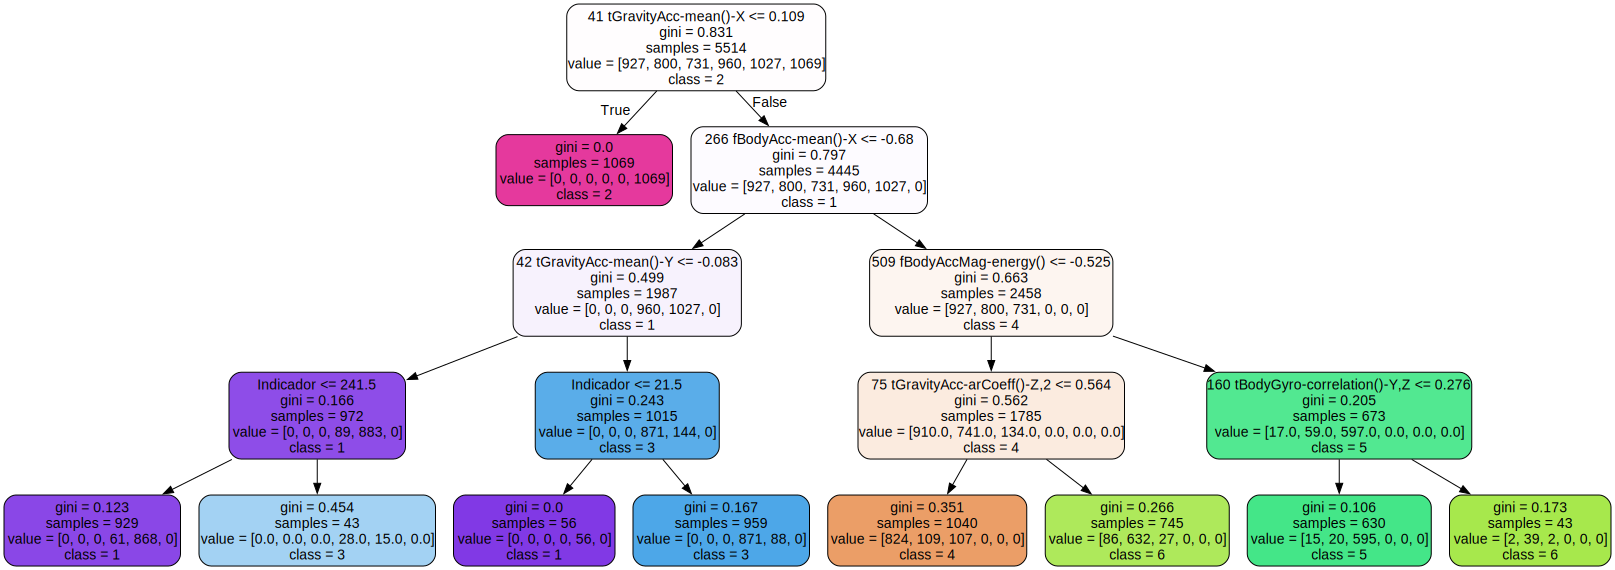

In [4]:
# Profundidade máxima max_depth = 4
# Desenvolvendo a árvore de decisão
tree = DecisionTreeClassifier(max_depth=4, random_state=42)
tree.fit(X_tr, y_tr)  

# Gerando a visualização da árvore ajustada
tree_dot = export_graphviz(tree, 
                           out_file=None, 
                           feature_names=X_tr.columns, 
                           class_names=[str(cls) for cls in y_tr["Atividade"].unique()],
                           filled=True, 
                           rounded=True)
tree_viz = graphviz.Source(tree_dot)
tree_viz

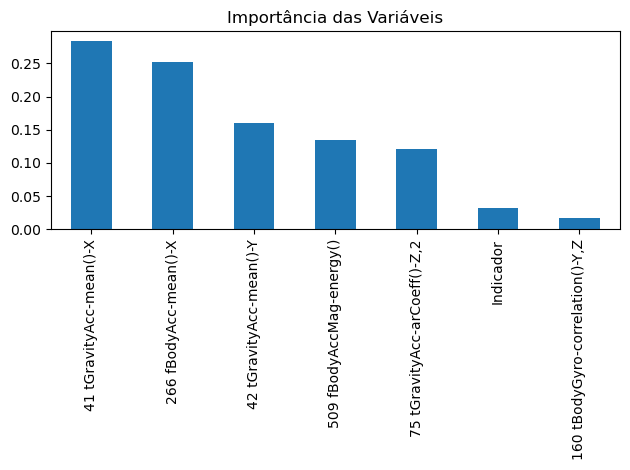

Nomes das 3 variáveis: ['41 tGravityAcc-mean()-X', '266 fBodyAcc-mean()-X', '42 tGravityAcc-mean()-Y']


In [5]:
# Pegando as 3 variáveis de maior importância 
forest_importances = pd.Series(tree.feature_importances_, index=X_tr.columns).sort_values(ascending=False).head(7)

# Plotando as importâncias como barras
fig, ax = plt.subplots()
forest_importances.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_title("Importância das Variáveis")
fig.tight_layout()
plt.show()
print(f"Nomes das 3 variáveis: {list(forest_importances.head(3).index)}")

In [6]:
# Selecionando essas variáveis na base de dados de estudo
X_tr = X_tr[["53 tGravityAcc-min()-X", "382 fBodyAccJerk-bandsEnergy()-1,8", "42 tGravityAcc-mean()-Y"]]
print("Base de treino:")
display(X_tr.head(2))
print ("----" * 30)
X_vld = X_vld[["53 tGravityAcc-min()-X", "382 fBodyAccJerk-bandsEnergy()-1,8", "42 tGravityAcc-mean()-Y"]]
print("Base de validação:")
display(X_vld.head(2))
print ("----" * 30)
X_tt = X_tt[["53 tGravityAcc-min()-X", "382 fBodyAccJerk-bandsEnergy()-1,8", "42 tGravityAcc-mean()-Y"]]
print("Base de teste:")
display(X_tt.head(2))

Base de treino:


,53 tGravityAcc-min()-X,"382 fBodyAccJerk-bandsEnergy()-1,8",42 tGravityAcc-mean()-Y
4044,0.995306,-0.999991,-0.044944
6115,0.984083,-0.999994,0.085902


------------------------------------------------------------------------------------------------------------------------
Base de validação:


,53 tGravityAcc-min()-X,"382 fBodyAccJerk-bandsEnergy()-1,8",42 tGravityAcc-mean()-Y
366,0.942291,-0.999977,-0.331111
6007,0.977435,-0.448752,-0.132259


------------------------------------------------------------------------------------------------------------------------
Base de teste:


,53 tGravityAcc-min()-X,"382 fBodyAccJerk-bandsEnergy()-1,8",42 tGravityAcc-mean()-Y
0,0.944461,-0.999011,-0.282719
1,0.944461,-0.999918,-0.289215


### 4. Construa uma árvore com as 3 melhores variáveis

Utilizando as três variáveis encontradas acima, construa uma árvore de decisão. Encontre o melhor ```ccp_alpha``` utilizando a base de validação, conforme a estrutura que vimos em aula.

In [7]:
%%time
# Calculando o caminho de poda na base de treino
tree = DecisionTreeClassifier(random_state=2360873)
tree.fit(X_tr, y_tr)
path = tree.cost_complexity_pruning_path(X_tr, y_tr)

ccp_alphas = path["ccp_alphas"]

ccp_alphas = ccp_alphas[ccp_alphas > 0]  # Apenas valores positivos
ccp_alphas = np.unique(ccp_alphas)  # Apenas valores únicos
print(f"Número total de ccp_alphas: {len(ccp_alphas)}")

# Reduzindo ccp_alphas
ccp_alphas_reduced = ccp_alphas[::5]
print(f"Número de ccp_alphas reduzidos: {len(ccp_alphas_reduced)}")

# Ajustando árvores para cada ccp_alpha reduzido
clfs = []
for ccp_alpha in ccp_alphas_reduced:
    clf = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    clf.fit(X_tr, y_tr)  # Treinando na base de treino
    clfs.append(clf)

# Encontrando o melhor alpha com base na acurácia na base de validação
best_score_vld = -1 
best_alpha = None
best_clf = None

for clf, alpha in zip(clfs, ccp_alphas_reduced):
    score = clf.score(X_vld, y_vld)  # Acurácia na base de validação
    if score > best_score_vld:
        best_score_vld = score
        best_alpha = alpha
        best_clf = clf
        
print("\nMelhor árvore selecionada na base de validação:")
print(f"Melhor alpha encontrado: {best_alpha:.6f}")
print(f"Acurácia na base de validação: {best_score_vld:.4f}")
print(f"Profundidade da melhor árvore: {best_clf.get_depth()}")

Número total de ccp_alphas: 200
Número de ccp_alphas reduzidos: 40

Melhor árvore selecionada na base de validação:
Melhor alpha encontrado: 0.000359
Acurácia na base de validação: 0.8966
Profundidade da melhor árvore: 16
CPU times: total: 1.31 s
Wall time: 1.34 s


### 5. Avaliação do modelo

Avalie a árvore encontrada no item anterior na base de testes.

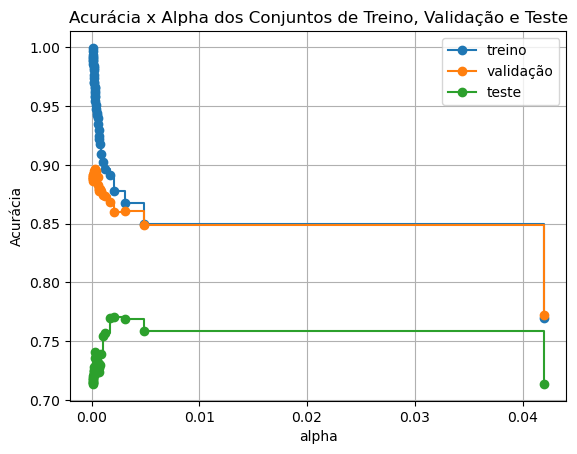

CPU times: total: 781 ms
Wall time: 766 ms


In [8]:
%%time
# Calculando a acurácia da base de treino e validação
tr_scores = [clf.score(X_tr, y_tr) for clf in clfs]
vld_scores = [clf.score(X_vld, y_vld) for clf in clfs]
tt_scores = [clf.score(X_tt, y_tt) for clf in clfs]

# Plotando acurácia x alpha
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x Alpha dos Conjuntos de Treino, Validação e Teste")
ax.plot(ccp_alphas_reduced, tr_scores, marker='o', label="treino", drawstyle="steps-post")
ax.plot(ccp_alphas_reduced, vld_scores, marker='o', label="validação", drawstyle="steps-post")
ax.plot(ccp_alphas_reduced, tt_scores, marker='o', label="teste", drawstyle="steps-post")
ax.legend()
plt.grid(True)
plt.show()

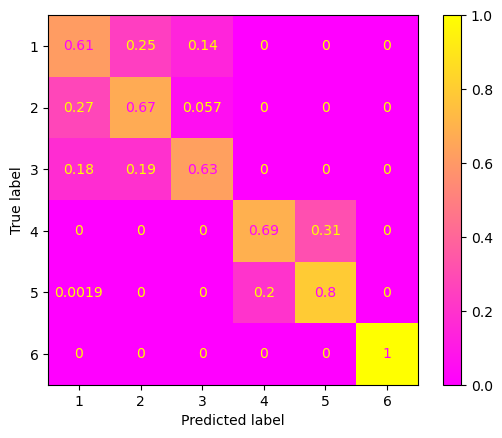

In [9]:
# Matriz de confusão para a melhor árvore na base de teste
ConfusionMatrixDisplay.from_estimator(
    best_clf,
    X_tt,
    y_tt,
    cmap=plt.cm.spring,
    normalize='true'
)

Ao analisarmos os gráficos alcançados após a escolha das variáveis mais adequadas e do uso da base de validação, nessa tarefa, percebemos um aumento da acurácia calculada, sendo o valor mínimo superior a 60% , e o máximo 100% (quando analisamos o rótulo da atividade 6). Esse ajuste se mostra eficiente para a utilização prática desse modelo.